In [ ]:
!nvidia-smi

In [1]:
import os
import torch
import torch.backends.mps as mps
from torchvision import datasets, transforms


In [2]:
if mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
        ])


In [4]:
download_state = True if not os.path.exists('./data/MNIST') else False
trainset = datasets.MNIST(root='./data', train=True, download=download_state, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
test_set = datasets.MNIST(root='./data', train=False, download=download_state, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [5]:
torch.backends.cudnn.enabled = True

In [6]:
from torch import nn
from torch.nn import functional as F
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

model = CNN_model().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model

CNN_model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in trainloader: # As our train_loader is batch size of 100 and had input images and corresponding labels
    inputs = inputs.to(device)  # Put our inputs and labels in the device as our model is also in the device
    labels = labels.to(device)
    outputs = model(inputs)   # giving input to our model to get corresponding output
    loss = criterion(outputs, labels) # comparing out model's output to original labels
    
    optimizer.zero_grad()  ##sets the initial gradient to zero
    loss.backward()  ## The whole calculated loss is then back propogated to the model
    optimizer.step()  ## Then the weights are updated by doing their derivative w.r.t the Loss
    
    _, preds = torch.max(outputs, 1) # Then we select the max value of raw output and consider it as our prediction. We select it from 10 o/ps
    running_loss += loss.item()  # total loss of 1 epoch
    running_corrects += torch.sum(preds == labels.data) #total accuracy of 1 epoch

  else:
    with torch.no_grad(): # This we done to set no gradient as we do not need it for val as our model is already trained.
      for val_inputs, val_labels in testloader:
        val_inputs = val_inputs.to(device)  # Put our val_inputs and labels in the device as our model is also in the device
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(trainloader)
    epoch_acc = running_corrects.float()/ len(trainloader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(testloader)
    val_epoch_acc = val_running_corrects.float()/ len(testloader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

/var/folders/fs/hcrv5j_50kx2qdrl866spl8r0000gn/T/ipykernel_90115/1075259720.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
print(running_loss_history)

[0.2589147186934948, 0.21909055761744578, 0.1981377192556858, 0.18089402463535467, 0.170021446151038, 0.160351133381327, 0.15122147481689852, 0.14614352780183157, 0.14138950791433452, 0.1355874586785833, 0.13049602460811535, 0.12439396414545675, 0.12210823264991244, 0.11823889732944469, 0.11763371532633901]


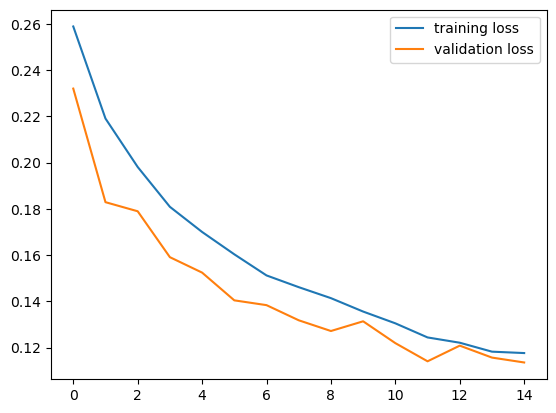

In [ ]:
import matplotlib.pyplot as plt
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
print(running_corrects_history)

[tensor(29.5392, device='cuda:0'), tensor(29.9461, device='cuda:0'), tensor(30.1493, device='cuda:0'), tensor(30.2976, device='cuda:0'), tensor(30.3909, device='cuda:0'), tensor(30.5051, device='cuda:0'), tensor(30.5819, device='cuda:0'), tensor(30.6384, device='cuda:0'), tensor(30.6773, device='cuda:0'), tensor(30.7008, device='cuda:0'), tensor(30.7973, device='cuda:0'), tensor(30.8101, device='cuda:0'), tensor(30.8453, device='cuda:0'), tensor(30.8683, device='cuda:0'), tensor(30.8645, device='cuda:0')]


In [ ]:
plt.plot(running_corrects_history.cpu().numpy(), label='training accuracy')


In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
mnist = tf.keras.datasets.mnist
tf_mnist_train_set, tf_mnist_test_set = mnist.load_data()

In [3]:
tf_train_images, tf_train_labels = tf_mnist_train_set
tf_test_images, tf_test_labels = tf_mnist_test_set
tf_train_images = tf_train_images / 255.0
tf_test_images = tf_test_images / 255.0

In [4]:
tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])


/Users/chanifrusydi/miniconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-24 19:02:05.939536: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-24 19:02:05.939563: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-24 19:02:05.939579: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-24 19:02:05.940003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-24 19:02:05.940031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory

In [5]:
tf_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,154 (1.61 MB)

 Trainable params: 422,154 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
tf_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = tf_model.fit(tf_train_images, tf_train_labels, validation_split=0.1, batch_size=64, epochs=10)

Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9903 - loss: 0.0301 - val_accuracy: 0.9915 - val_loss: 0.0343
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9915 - loss: 0.0274 - val_accuracy: 0.9923 - val_loss: 0.0305
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9933 - loss: 0.0203 - val_accuracy: 0.9930 - val_loss: 0.0292
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9936 - loss: 0.0197 - val_accuracy: 0.9927 - val_loss: 0.0296
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9941 - loss: 0.0168 - val_accuracy: 0.9912 - val_loss: 0.0365
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9934 - loss: 0.0194 - val_accuracy: 0.9922 - val_loss: 0.0317
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9948 - loss: 0.0160 - val_accuracy: 0.9920 - val_loss: 0.0344
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.9955 - loss: 0.0133 - 

In [8]:
test_loss, test_acc = tf_model.evaluate(tf_test_images,  tf_test_labels, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

313/313 - 2s - 7ms/step - accuracy: 0.9930 - loss: 0.0252

Test accuracy: 0.9929999709129333

Test loss: 0.025238798931241035


In [9]:
import matplotlib.pyplot as plt
plt.style.use("default")

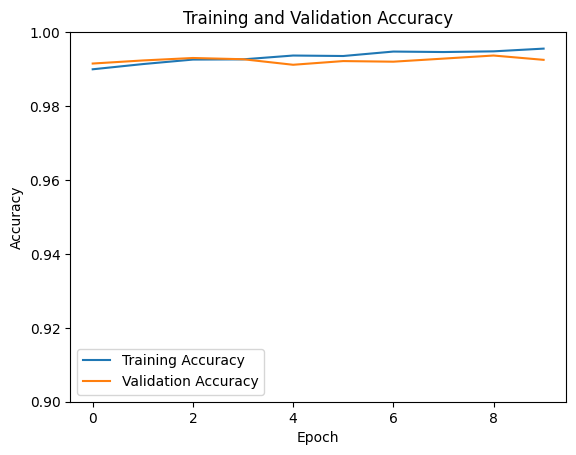

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend()
plt.show()

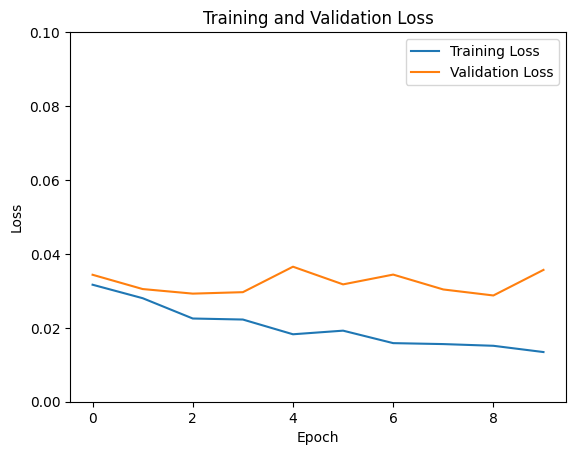

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.1])
plt.legend()
plt.show()

In [ ]:
tf_model.save('mnist_model.h5')